<a href="https://colab.research.google.com/github/ric4234/AI-Fridays/blob/main/Analisi%20di%20Serie%20Temporali/02_Prophet.ipynb" target="_parent\"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prophet Model

Prophet is a model developed by Meta (Facebook), used by Meta itself to make reliable forecasts for planning and goal-setting. It has been released by Meta as open source, allowing for free usage and customization.

Prophet allows for the estimation of trends and seasonalities on a monthly, weekly, and daily basis.

Prophet is an additive regression model based on three main components:

*   **Trend**: A segmented linear or logistic growth trend. Prophet automatically detects changes in the trend by selecting changepoints from the data.
*   **Annual and weekly seasonal components**: Modeled using Fourier series with periods P=365.25 and P=7.
*   **List of holidays/significant days**: User can specify holidays (Christmas, New Year, Easter, etc.) or relevant days (e.g., Black Friday)

Prophet forecast is represented in the following way:

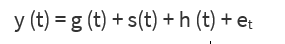

Where g(t) is the trend component, s(t) the seasonality, h(t) the holidays effect and e(t) epresents random variations assumed to be normally distributed (Gaussian). Each function (g, s, h) has its own weight and is characterized by a set of parameters that need to be optimized to improve the model's fit to the data.

Finally, Prophet can be used for univariate models only. This means that  Prophet only makes forecasts with only one dependent variable. If you’d want to adapt to multivariate forecasts, you’d need to train a Prophet for each dependent variable separately.





#### 1 - Importing Data

Data: Daily number of shipments made by a courier service

Period of Record: June 2021 - February 2024

Number of observations: 1004
Number of variables: 2
Variable name definitions:

1.   date - sample date in YYYY-MM-DD format
2.   numero_spedizioni - number of shipments

Source: https://github.com/ric4234/AI-Fridays/blob/main/Dataset/dataset_spedizioni.csv

Raw Data Source: https://github.com/ric4234/AI-Fridays/raw/main/Dataset/dataset_spedizioni.csv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   data               1004 non-null   datetime64[ns]
 1   numero_spedizioni  1004 non-null   int64         
 2   day_of_week        1004 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 23.7+ KB
None
        data  numero_spedizioni day_of_week
0 2021-06-01             358890     Tuesday
1 2021-06-02               1192   Wednesday
2 2021-06-03             424296    Thursday
3 2021-06-04             346785      Friday
4 2021-06-05                 10    Saturday


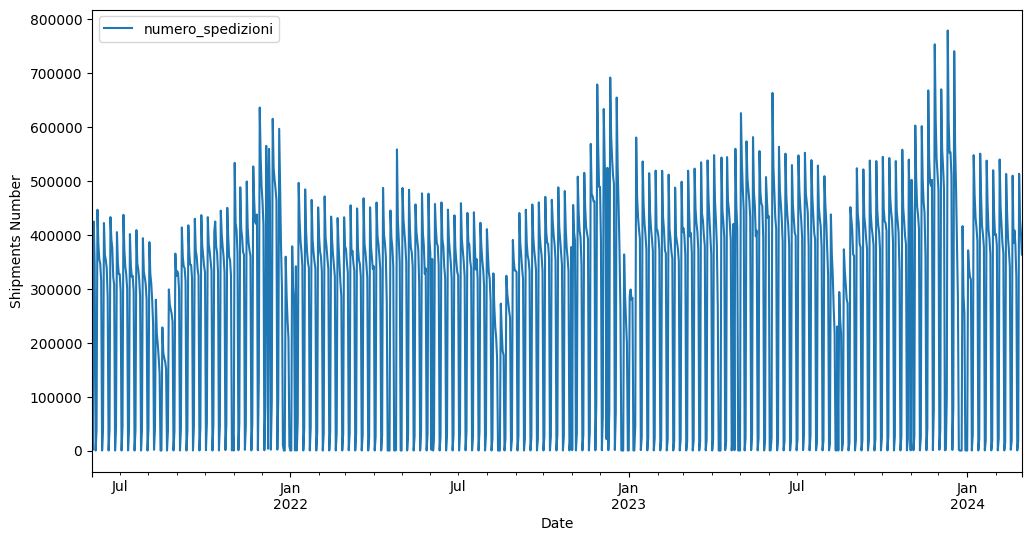

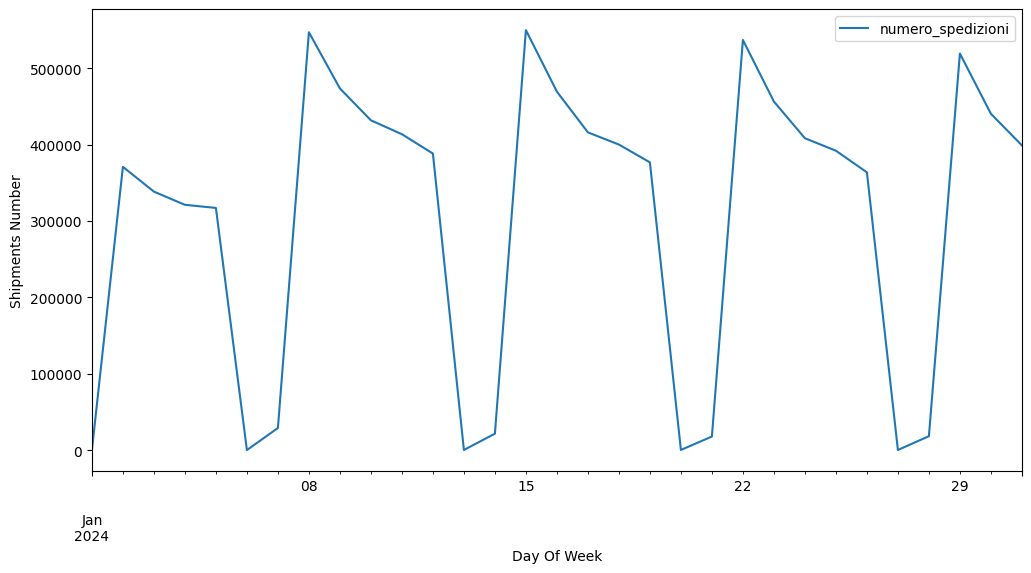

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# URL of the dataset on GitHub
url = "https://github.com/ric4234/AI-Fridays/raw/main/Dataset/dataset_spedizioni.csv"
# Load the dataset into a pandas DataFrame
df = pd.read_csv(url)
# Convert the 'data' column to datetime format
df['data'] = pd.to_datetime(df['data'])
df['day_of_week'] = df['data'].dt.day_name()
# Display the informations of the dataframe
print(df.info())
# Display the first few rows of the DataFrame to verify it's loaded correctly
print(df.head())

ax = df.plot(x='data', y='numero_spedizioni',figsize=(12,6))
ax.set_ylabel('Shipments Number')
ax.set_xlabel('Date')

# Display a data subset to explore weekly patterns
january_2024_data = df[(df['data'].dt.month == 1) & (df['data'].dt.year == 2024)]

ax_2 = january_2024_data.plot(x='data', y='numero_spedizioni',figsize=(12,6))
ax_2.set_ylabel('Shipments Number')
ax_2.set_xlabel('Day Of Week')

  # Adjust the width as needed
plt.show()

In [40]:
df['data'].dt.month

0       6
1       6
2       6
3       6
4       6
       ..
999     2
1000    2
1001    2
1002    2
1003    2
Name: data, Length: 1004, dtype: int64

#### 2 - Plotting Data

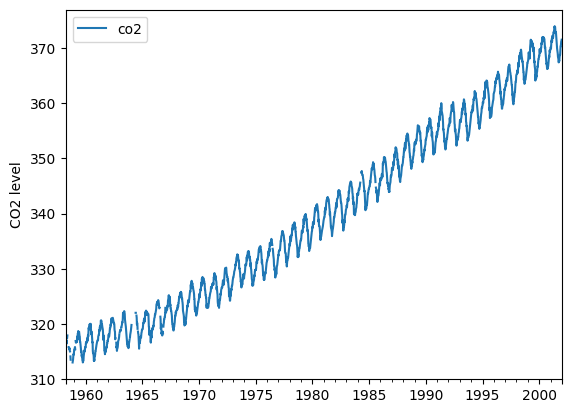

In [ ]:
import matplotlib.pyplot as plt
ax = data.plot()
ax.set_ylabel('CO2 level (ppmv)')
plt.show()

This data shows a very obvious sign of an upward trend, which is fairly constant. And
there is also a very clear seasonality pattern in this data (up and down).
Then, we should look at its autocorrelation and partial autocorrelation functions. However, both autocorrelation (ACF) and partial autocorrelation (PACF) plots are relevant only when applied to stationary data.
For this reason, in the next section we will plot ACF and PACF on the differenced data


#### 3 - ACF and PACF plots

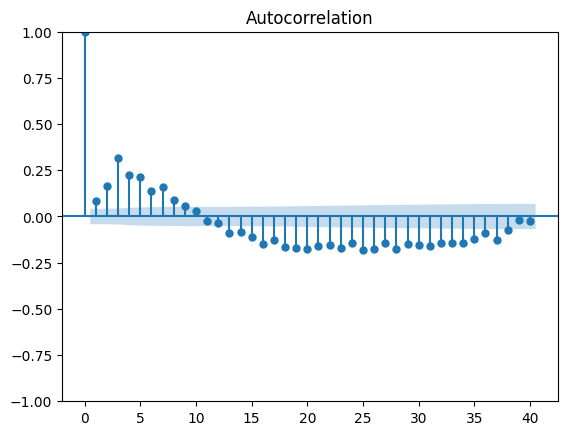

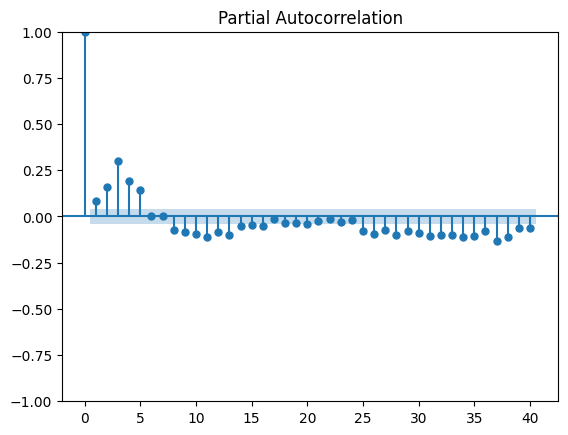

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data.diff().dropna(), lags=40)
plot_pacf(data.diff().dropna(), lags=40)
plt.show()

In general, if there is no decay of the correlations toward zero, this means the data is not stationary. In this case, data has been differenced and seems stationary. However, the decay occurs relatively late in the autocorrelation. For this reason, we can increase the number of lags and see both plots again

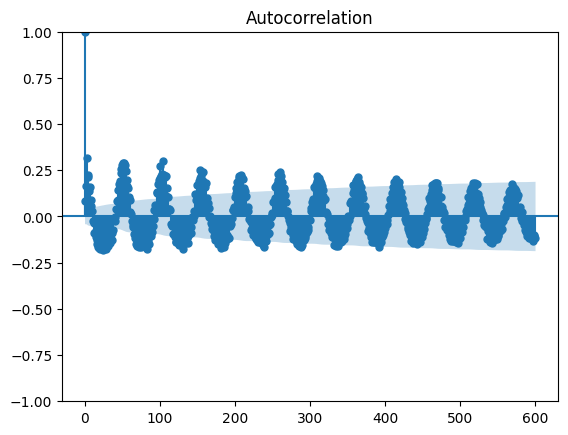

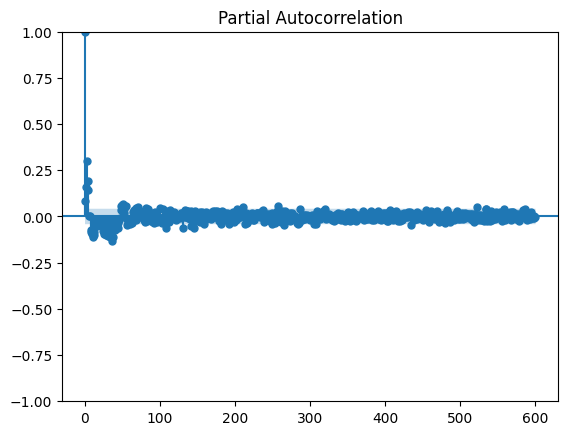

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data.diff().dropna(), lags=600)
plot_pacf(data.diff().dropna(), lags=600)
plt.show()

Spiegare come questo influisce nella scelta dell'iperparametro I

#### 4 - Hyperparameter tuning

The ARIMA(p,I,q) model has three hyperparameters:


*   The order of the AR process denoted by p
*   The order of the MA process denoted by q
*   The order of integration denoted by I




In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
data_array = data[['co2']].values
avg_errors = []
for p in range(6):
  for q in range(6):
    for i in range(3):
      errors = []
      tscv = TimeSeriesSplit(test_size=10)
      for train_index, test_index in tscv.split(data_array):
        X_train, X_test = data_array[train_index], data_array[test_index]
        X_test_orig = X_test
        fcst = []
        for step in range(10):
          try:
            mod = ARIMA(X_train, order=(p,i,q))
            res = mod.fit()
            fcst.append(res.forecast(steps=1))
          except:
            print('errorred')
            fcst.append(-9999999.)
        X_train = np.concatenate((X_train, X_test[0:1,:]))
        X_test = X_test[1:]
      errors.append(r2_score(X_test_orig, fcst))

  pq_result = [p, i, q, np.mean(errors)]
  print(pq_result)
  avg_errors.append(pq_result)

  avg_errors = pd.DataFrame(avg_errors)
  avg_errors.columns = ['p', 'i', 'q', 'error']
  avg_errors.sort_values('error', ascending=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.p

[0, 2, 5, -3.8668102290329607]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10

[1, 2, 5, -3.923661042006583]


<ipython-input-11-7e53defe5c7c>:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  avg_errors.append(pq_result)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


#### 5 - Best forecast result

In [ ]:
X_train, X_test = data_array[:-10], data_array[-10:]
X_test_orig = X_test
fcst = []
for step in range(10):
  mod = ARIMA(X_train, order=(4,1,4))
  res = mod.fit()
  fcst.append(res.forecast(steps=1))
  X_train = np.concatenate((X_train, X_test[0:1,:]))
  X_test = X_test[1:]
plt.plot(fcst)
plt.plot(X_test_orig)
plt.legend(['Predicted', 'Actual'])
plt.ylabel('CO2 Level')
plt.xlabel('Time Step of Test Data')
plt.show()